Alen Smajic (6510387)

In this assignmment we will do following things
1. Implement simple RNN cell (3 points)
2. Implement LSTM cell (3 points)
3. Implement LSTM taking inspiration from provided RNN Implementation (2 points)
4. Conceptual/Mathematical explanation of how LSTM solve vanishing gradients (2 points)

# Imports
Please install pytorch and torchvision 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.optim as optim

# Simple RNN cell
Here we will write the forward pass for a simple RNN.  PyTorch’s automatic differentiation engine will take care of backward pass for us. We have completed the init function for you.

## Exercise 1 : Please fill the forward function of simple RNN Cell

In [2]:
class SimpleRNNCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SimpleRNNCell, self).__init__()
        
        self.weights_x = torch.randn(input_dim, hidden_dim)  # Weights to apply to X (input to RNN)
        self.weights_h = torch.randn(hidden_dim, hidden_dim)  # Weights to apply to h (RNN's hidden state)
        
        self.bias = torch.zeros(1, hidden_dim)  # Bias 
    
    def forward(self, X, h_prev):   
        ################################# TODO: Please write the RNN forward pass below ###############
        # In the forward function we take X which is of dimension (batch size, input_dim) and multiply it 
        # by the model weights weights_x. Furthermore, we take the old state of the network h_prev which is
        # of dimension (batch size, hidden_dim) and multiply it by the model weights weights_h. Now that we
        # have two outputs of dimension (batch size, hidden_dim) we can add them together and additionally 
        # add the bias which has dimension (1, hidden_dim) and is applied to every row of our output. Finally
        # we get our new state h of dimension (batch_size, hidden_dim) after we apply the hyperbolic tangent
        # activation function to our output.
        h = torch.tanh(torch.mm(X, self.weights_x) + torch.mm(h_prev, self.weights_h) + self.bias)
        ###############################################################################################
        return h

# LSTM cell
Here we will write the forward pass for a LSTM.  PyTorch’s automatic differentiation engine will take care of backward pass for us. We have completed the init function  and some part of forward function for you.

## Exercise 2 : Please complete the forward function of LSTM Cell

In [3]:
class LSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LSTMCell, self).__init__()
        
        # input gate weights
        self.weights_input_Wx = torch.randn(input_dim, hidden_dim)     # Weights to apply to X (input to LSTM)
        self.weights_input_Wh = torch.randn(hidden_dim, hidden_dim)    # Weights to apply to h (LSTM's hidden state)
        self.bias_input_b = torch.zeros(1, hidden_dim)        
        
        # forget gate weights 
        self.weights_forget_Wx = torch.randn(input_dim, hidden_dim)    # Weights to apply to X (input to LSTM)
        self.weights_forget_Wh = torch.randn(hidden_dim, hidden_dim)   # Weights to apply to h (LSTM's hidden state)
        self.bias_forget_b = torch.zeros(1, hidden_dim)

        # cell memory weights
        self.weights_cell_Wx = torch.randn(input_dim, hidden_dim)      # Weights to apply to X (input to LSTM)
        self.weights_cell_Wh = torch.randn(hidden_dim, hidden_dim)     # Weights to apply to h (LSTM's hidden state)
        self.bias_cell_b = torch.zeros(1, hidden_dim)

        # output gate weights
        self.weights_output_Wx = torch.randn(input_dim, hidden_dim)    # Weights to apply to X (input to LSTM)
        self.weights_output_Wh = torch.randn(hidden_dim, hidden_dim)   # Weights to apply to h (LSTM's hidden state)
        self.bias_output_b = torch.zeros(1, hidden_dim)
    
    
    def forward(self, X, h_prev, c_prev):        
        
        # input gate
        input_gate = torch.sigmoid(torch.mm(h_prev, self.weights_input_Wh) + \
                                   torch.mm(X, self.weights_input_Wx) + self.bias_input_b)

        # forget gate 
        forget_gate = torch.sigmoid(torch.mm(h_prev, self.weights_forget_Wh) + \
                                    torch.mm(X, self.weights_forget_Wx) + self.bias_forget_b)
        
        # cell state update
        temp_cell_state = torch.tanh(torch.mm(h_prev, self.weights_cell_Wh) + \
                                          torch.mm(X, self.weights_cell_Wx) + self.bias_cell_b) 
        c = temp_cell_state * input_gate + forget_gate * c_prev
        
        ################### TODO: Write the update equation for output gate  and hidden state ######################
        # The output gate decides which information is being output from the cell state as the new state h. It takes
        # the input X and applies the model weights to it. Simillary it takes the old state h_prev and applies the 
        # model weights to it. At the end it adds these two matrices together and applies the bias term to every 
        # row. These steps are basically the same as in the simple RNN cell. The only difference is that this time
        # we use the sigmoid activation function. Finally, our output_gate should output a matrix of dimension
        # (batch size, hidden_dim) which we now elementwise multiply with the cell state. Before we do that we have 
        # to apply the hyperbolic tangent activation function to the cell state to push the values to be between -1 
        # and 1. At the end we return the new state h which contains only the parts of the cell state we decided to.
        output_gate = torch.sigmoid(torch.mm(X, self.weights_output_Wx) + torch.mm(h_prev, self.weights_output_Wh) + self.bias_output_b)
        h = torch.tanh(c) * output_gate
        
        ############################################################################################################
        
        return h, c

# SimpleRNN

Here we implement a RNN using the RNN cell we defined above. It takes number of time steps as the additional input to generate a sequential output given a sequential input

In [4]:
class SimpleRNN(nn.Module):
    def __init__(self, batch_size, input_dim, hidden_dim, time_steps):
        super(SimpleRNN, self).__init__()
        self.time_steps = time_steps
        self.rnn = SimpleRNNCell(input_dim, hidden_dim)
        self.hx = torch.zeros(batch_size, hidden_dim) # initialize hidden state
        
        # Initializing RNN weights with Xavier initialization 
        rnn_params = vars(self.rnn)
        for name, param in rnn_params.items():
            if "weights" in name:
                torch.nn.init.xavier_uniform(param)
        
    def forward(self, X, hx = None):
        output = []
        if hx is not None:
            self.hx = hx
            
        for i in range(self.time_steps):
            self.hx = self.rnn(X[i], self.hx)
            output.append(self.hx)
        
        return output, self.hx

# Loading MNIST dataset

Here we load MNIST data which we will use to evaluate our RNN

In [6]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# Visualizing the dataset 
Here we visualize some example images in the dataset

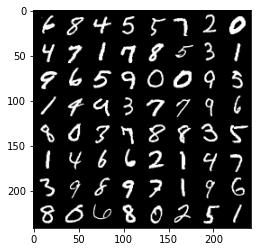

In [7]:
# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# Defining an ImageRNN

Here we take a 28 x 28 image as the input. At each time step the RNN looks at one row making a total of 28 timesteps to look at full image. We apply a RNN layer followed by a fully connected layer to do final classification.

In [8]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, input_dim, hidden_dim, output_dim):
        super(ImageRNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.basic_rnn = SimpleRNN(self.batch_size,self.input_dim, self.hidden_dim,self.n_steps) 
        
        self.FC = nn.Linear(self.hidden_dim, self.output_dim)
        
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        h = torch.zeros(self.batch_size, self.hidden_dim)
        self.batch_size = X.size(1)
        rnn_out, self.hidden = self.basic_rnn(X, hx= h) 
        out = self.FC(self.hidden)
        
        return out.view(-1, self.output_dim) # batch_size X n_output

# Training parameters

In [9]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPOCHS = 10

# Setting up optimizer and cross entropy loss function

In [10]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

<ipython-input-4-53908684f1f0>:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(param)


# Training Loop
It run for N_EPOCHS and prints training and test accuracy after every epoch

In [11]:
for epoch in range(N_EPOCHS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i_train, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 
        if not inputs.size()[0] == 64:
            continue
        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    test_acc = 0.0
    for i_test, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs = inputs.view(-1, 28, 28)
        if not inputs.size()[0] == 64:
            continue
        outputs = model(inputs)

        test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f | Test Accuracy: %.2f' 
          %(epoch, train_running_loss / i_train, train_acc/i_train, test_acc/i_test))

Epoch:  0 | Loss: 1.1509 | Train Accuracy: 63.53 | Test Accuracy: 64.73
Epoch:  1 | Loss: 1.0536 | Train Accuracy: 67.10 | Test Accuracy: 68.26
Epoch:  2 | Loss: 1.0356 | Train Accuracy: 67.76 | Test Accuracy: 68.64
Epoch:  3 | Loss: 1.0304 | Train Accuracy: 68.05 | Test Accuracy: 70.47
Epoch:  4 | Loss: 1.0124 | Train Accuracy: 68.53 | Test Accuracy: 67.24
Epoch:  5 | Loss: 1.0139 | Train Accuracy: 68.75 | Test Accuracy: 68.75
Epoch:  6 | Loss: 1.0109 | Train Accuracy: 68.71 | Test Accuracy: 69.99
Epoch:  7 | Loss: 0.9972 | Train Accuracy: 69.19 | Test Accuracy: 68.89
Epoch:  8 | Loss: 1.0018 | Train Accuracy: 69.09 | Test Accuracy: 70.80
Epoch:  9 | Loss: 0.9833 | Train Accuracy: 69.46 | Test Accuracy: 69.20


# Implementing LSTM
Here we implement a LSTM using the LSTM cell we defined above. It takes number of time steps as the additional input to generate a sequential output given a sequential input.

## Exercise 3 Please complete the forward pass of LSTM
Hint: Remember unlike RNN, LSTM has two hidden variables : hidden state and cell state that are updated at every time point

In [12]:
class LSTM(nn.Module):
    def __init__(self, batch_size, input_dim, hidden_dim, time_steps):
        super(LSTM, self).__init__()
        self.time_steps = time_steps
        self.lstm = LSTMCell(input_dim, hidden_dim)
        self.hx = torch.zeros(batch_size, hidden_dim) # initialize hidden state
        self.cx = torch.zeros(batch_size, hidden_dim) # initialize cell state
        lstm_params = vars(self.lstm)
         
        for name, param in lstm_params.items():
            if "weights" in name:
                torch.nn.init.xavier_uniform(param)
                
    def forward(self, X, hx = None,cx = None):
        output = []
        # for each time step
        if hx is not None:
            self.hx = hx
        if cx is not None:
            self.cx = cx
            
        ################################## TODO: Run a for loop to update LSTM hidden and cell state ######################
        ################################## Hint: take inspiration from how RNN hidden state was updated ################### 
        # Here we iterate over all time steps which are predefined by our data. Our data is of dimension 
        # (time_steps, batch_size, input_dim). So at each time step we look at our batch of data where each sample has 
        # input_dim amount of features and it is different at every time step.
        # So the LSTM iterates over all time steps and takes these batches of samples X[i] alongside with the old state hx
        # and the old cell state cx to produce a new state hx and a new cell state cx. Both of them have dimension 
        # (batch_size, hidden_dim) and are used to overwrite the old states. Finally, the new state hx is appended to our
        # output list to store the current output of the respective time step.
        for i in range(self.time_steps):
            self.hx, self.cx = self.lstm(X[i], self.hx, self.cx)
            output.append(self.hx)        
        ###################################################################################################################
        return output, self.hx

# Defining ImageLSTM
Here we take a 28 x 28 image as the input. At each time step the LSTM looks at one row making a total of 28 timesteps to look at full image. We apply a LSTM layer followed by a fully connected layer to do final classification.

In [13]:
class ImageLSTM(nn.Module):
    def __init__(self, batch_size, n_steps, input_dim, hidden_dim, output_dim):
        super(ImageLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.basic_lstm = LSTM(self.batch_size,self.input_dim, self.hidden_dim,self.n_steps) 
        
        self.FC = nn.Linear(self.hidden_dim, self.output_dim)
        
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        h = torch.zeros(self.batch_size, self.hidden_dim)
        c = torch.zeros(self.batch_size, self.hidden_dim)
        self.batch_size = X.size(1)
        rnn_out, self.hidden = self.basic_lstm(X, hx= h, cx =c) 
        out = self.FC(self.hidden)
        
        return out.view(-1, self.output_dim) # batch_size X n_output

# Setting up optimizer and cross entropy loss function

In [14]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageLSTM(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

<ipython-input-12-00299144f0ec>:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(param)


# Training Loop
It run for N_EPOCHS and prints training and test accuracy after every epoch

In [15]:
for epoch in range(N_EPOCHS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i_train, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 
        if not inputs.size()[0] == 64:
            continue
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    test_acc = 0.0
    for i_test, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs = inputs.view(-1, 28, 28)
        if not inputs.size()[0] == 64:
            continue
        outputs = model(inputs)

        test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f | Test Accuracy: %.2f' 
          %(epoch, train_running_loss / i_train, train_acc/i_train, test_acc/i_test))

Epoch:  0 | Loss: 1.2150 | Train Accuracy: 59.15 | Test Accuracy: 64.19
Epoch:  1 | Loss: 1.0136 | Train Accuracy: 65.33 | Test Accuracy: 67.20
Epoch:  2 | Loss: 0.9514 | Train Accuracy: 67.64 | Test Accuracy: 68.10
Epoch:  3 | Loss: 0.9098 | Train Accuracy: 68.88 | Test Accuracy: 68.53
Epoch:  4 | Loss: 0.8818 | Train Accuracy: 69.99 | Test Accuracy: 70.55
Epoch:  5 | Loss: 0.8589 | Train Accuracy: 70.85 | Test Accuracy: 71.20
Epoch:  6 | Loss: 0.8435 | Train Accuracy: 71.17 | Test Accuracy: 71.88
Epoch:  7 | Loss: 0.8277 | Train Accuracy: 72.02 | Test Accuracy: 72.19
Epoch:  8 | Loss: 0.8161 | Train Accuracy: 72.27 | Test Accuracy: 72.55
Epoch:  9 | Loss: 0.8039 | Train Accuracy: 72.77 | Test Accuracy: 73.93


# Summary 
In this assignment we implemented the forward pass of RNN and LSTM using pytorch. In practice, you do not need to implement these layers as pytorch already provides implementation of these two and other recurrent layers such as GRU. In fact, if you might get higher accuracy by replacing implemented version with pytorch version of RNNs and LSTMs due to better initialization. Please feel free to experiment and write your observations in the extra cell provided below.  

## Exercise 4
You might have observed that LSTM slightly outperforms RNN in the above example. In the lecture we briefly discussed why LSTM mitigates the issue of vanishing gradients using the gates. Please go through the following links for more details and answer succintly either mathematically or conceptually why LSTMs do not face the issue of vanishing gradients.

1. [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
2. [Understanding, Deriving and Extending the LSTM](https://r2rt.com/written-memories-understanding-deriving-and-extending-the-lstm.html)
3. [Why LSTMs Stop Your Gradients From Vanishing](https://weberna.github.io/blog/2017/11/15/LSTM-Vanishing-Gradients.html)
4. [cs224 slides on LSTM](https://web.stanford.edu/class/cs224n/slides/cs224n-2019-lecture07-fancy-rnn.pdf)

## Your Answer:
Simillary to deep NN, the simple RNN architecture also suffers from the problem of vanishing gradients. Upon training such networks by applying backprop through time to calculate the gradient of the loss function with respect to an earlier state of the RNN $\frac{∂E}{∂h_{1}}$ we can examine that we have to repeatedly multiply the local gradients (of subsequent states) $\frac{∂h_t}{∂h_{t−1}}$ with the same weight matrix $W_R$, which was used in the forward pass to calculate the new state of the RNN by multiplying it with the old state $h_t = tanh(W_I*x_t + W_R*h_{t-1})$. The gradient looks like this: $\frac{∂h_k}{∂h_1}=\prod_i^k diag(f'(W_I*x_i + W_R*h_{i-1}))*W_R$. This repeated multiplication with the same weight matrix $W_R$ can pose a risk since if the weight matrix is small (largest eigenvalues < 1), then the backpropagated gradient gets vanishingly smaller as it is further backpropagated to the earlier layers. "In vanilla RNNs, the terms $\frac{∂h_t}{∂h_{t−1}}$ will eventually take on a values that are either always above 1 or always in the range [0,1], this is essentially what leads to the vanishing/exploding gradient problem." [ https://weberna.github.io/blog/2017/11/15/LSTM-Vanishing-Gradients.html ] This results in a poor training/learning ability of layers which are near the input and ultimately results in the network not remembering previous information and poor performance. 



LSTMs mitigate this problem by implementing a "Long short-term memory" called the cell state. It is used to store information and it is being controlled by the so called gates. We have a forget gate which decides which information is being removed from the memory, we have an input gate which decided which information is being stored in the memory and lastly we have an output gate which decides which information is being outputed from the memory. The important aspect when training these networks is the cell state which is crucial in order to calculate the gradients. When applying backprop to LSTMs we will need to compute the gradients of new cell states with respect to old cell states in order to backprop the gradient to the earlier layers. We know that the new cell state is defined by two terms which are added together. The element-wise multiplication of the old cell state and the forget gate $f*C_{t-1}$ (which basically drops some information), and the element-wise multiplication of the candidate cell state and the input gate $i*\tilde{C_t}$ (which basically decides which new information should be stored). Each of these functions is a function of $C_{t-1}$, because they are calculated from $h_{t-1}$. If we now calculate the gradient we get the following term: $\frac{∂C_t}{∂C_{t−1}} = (\frac{∂C_t}{∂f_{t}}*\frac{∂f_t}{∂h_{t−1}}*\frac{∂h_{t-1}}{∂C_{t−1}}) + (\frac{∂C_t}{∂i_{t}}*\frac{∂i_t}{∂h_{t−1}}*\frac{∂h_{t-1}}{∂C_{t−1}}) + (\frac{∂C_t}{∂\tilde{C_t}}*\frac{∂\tilde{C_t}}{∂h_{t−1}}*\frac{∂h_{t-1}}{∂C_{t−1}}) + \frac{∂C_t}{∂C_{t-1}}$
If we now derive these gradients we can clearly see that we do not have a weight matrix which is repeatedly applied anymore, but rather different terms which can at any time step either take values that are greater than 1 or values in the range [0,1]. Unlike the vanilla RNN where the repeated multiplication by $W_R$ forces the gradient to either converge to zero or infinity, there is nothing that would force this behaviour in a LSTM. 

# Further Readings:

Recently for modelling sequences as well as images attention models have become more popular and have outperformed LSTMs and CNNs. If you are interested you may go through these blog posts.
1. [Attention models](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html)
2. [Transformer family](https://lilianweng.github.io/lil-log/2020/04/07/the-transformer-family.html)

# Observations:
Feel free to write about your observations in the above tutorial. Leaving this cell empty is also fine as this is not used for grading.

## Your answer:
I found it very interesting how we can use RNNs to do tasks like handwriting recognition on the MNIST dataset. The approach is much different because we do not use our data like we did in our CNNs, where the input is basically a matrix containing a batch of different image samples. In the RNN we had to transform this input so that the batch only contains one vector of the image (one row of pixel values), so that we had many batches which represented our initial input from the CNN. So instead of inputing a batch of images we rather input a whole set of batches, where each batch contains one row of pixel values from the same sample (a small portion of the image). The RNN actually manages to learn the previous portions of the image and to remember them so it can classify it at the end.

# Credits
This assignment is based on this [blog post](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)  explaining how to use LSTMs for MNIST digit classification 

